In [145]:
!pip install nltk

In [141]:
import enchant

In [1]:
# Web scraper for Edmunds
# Selenium is used to handle the javascript on a website

#Importing libraries
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import re
import pandas as pd
import os     #to manipulate files

import warnings
warnings.filterwarnings('ignore')

In [51]:
chrome_path = r'/Users/jitu/Documents/Fall/UGC/chromedriver'
# prepend it with r because of the backslash characters

driver = webdriver.Chrome(chrome_path) # This will open up a chrome window

page = 703
url = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p" + str(page)

driver.get(url)  # Open that website

In [1]:
userlist = []
datelist = []
postlist = []
quotelist = []
while len(postlist)<4000:
    #User
    users = driver.find_elements_by_class_name('Username')
    for user in users:
        userlist.append(user.text)
    
    #Date
    dates = driver.find_elements_by_class_name('DateCreated')
    for date in dates:
        datelist.append(date.text)
    
    # This is the list of all the comments
    posts = driver.find_elements_by_class_name('Item-Body')
    for post in posts:
        postlist.append(post.text)

    # This is the list of the blockquotes that you don't want
    quotes = driver.find_elements_by_class_name('Quote')
    for quote in quotes:
        quotelist.append(quote.text)
        
    page = page - 1
    url = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p" + str(page)

    driver.get(url)

In [182]:
len(postlist)

0

In [20]:
# Now you have to delete quotes from the posts
for j in range(0,len(quotelist)):
    for i in range(0,len(postlist)):
        if (quotelist[j] in postlist[i]):
            postlist[i]=postlist[i].replace(quotelist[j],'')  

In [21]:
len(postlist)

4013

In [22]:
df_raw = pd.DataFrame(datelist)
df_raw['Users'] = userlist
df_raw['Text'] = postlist
df_raw.columns = ['Date','User','Text']

In [28]:
df_raw.head(10)['Text']

0    This seems like a good deal in terms of used e...
1    nice color combo on the TLX. But I really don'...
2    Yeah, the Tech package for the TLX is expensiv...
3    Thinking about the idea @stickguy had of keepi...
4    Entry level luxury sedan sales for last month....
5    Ouch\n2018 Hyundai Elantra Sport (mine), and 2...
6    But falling sales for ELL cars probably helps ...
7    But, will be nice if they keep the pricing lik...
8    stickguy said:\nBut, will be nice if they keep...
9    Most of the time, when I have checked, the Acu...
Name: Text, dtype: object

In [153]:
postfile_name = r'/Users/jitu/Documents/Fall/UGC/postfile.csv'
df_raw.to_csv(postfile_name)

In [183]:
import pandas as pd
posts=pd.read_csv('/Users/jitu/Documents/Fall/UGC/postfile.csv')

In [184]:
posts.head(5)

,Unnamed: 0,Date,User,Text
0,0,September 28,benjaminhf,This seems like a good deal in terms of used e...
1,1,September 28,stickguy,nice color combo on the TLX. But I really don'...
2,2,September 28,benjaminhf,"Yeah, the Tech package for the TLX is expensiv..."
3,3,October 3,benjaminhf,Thinking about the idea @stickguy had of keepi...
4,4,October 3,benjaminhf,Entry level luxury sedan sales for last month....


In [185]:
posts = posts.replace(r'\n',' ', regex=True)
posts = posts.replace(r'\r',' ', regex=True)
posts.head(10)['Text']

0    This seems like a good deal in terms of used e...
1    nice color combo on the TLX. But I really don'...
2    Yeah, the Tech package for the TLX is expensiv...
3    Thinking about the idea @stickguy had of keepi...
4    Entry level luxury sedan sales for last month....
5    Ouch 2018 Hyundai Elantra Sport (mine), and 20...
6    But falling sales for ELL cars probably helps ...
7    But, will be nice if they keep the pricing lik...
8    stickguy said: But, will be nice if they keep ...
9    Most of the time, when I have checked, the Acu...
Name: Text, dtype: object

In [186]:
import nltk
import re
from nltk.tokenize import sent_tokenize, word_tokenize

In [187]:
from string import punctuation
def unique_words(s):
# Remove punctuation & others, convert to lower and finally stopwords
    s=str(s)
    for p in punctuation:
        s =s.replace(p,'')
    s=s.lower()
    return list(set(re.findall('\w+',s)))

posts['unique_words_list']=posts['Text'].map(unique_words)

In [188]:
posts['unique_words_list'].head(5)

0    [24, entrylevel, true, is, local, i, strange, ...
1    [least, hyundai, i, tech, have, combo, dont, b...
2    [ive, acurawatch, sound, is, expensive, blind,...
3    [ive, is, i, half, have, year, keeping, though...
4    [is, 11, es, mkz, 467, 244, sedan, for, well, ...
Name: unique_words_list, dtype: object

In [189]:
def unique_words(s):
# Remove punctuation & others, convert to lower and finally stopwords
    s=str(s)
    for p in punctuation:
        s =s.replace(p,'')
    s=s.lower()
    return list(set(re.findall('\w+',s)))

In [190]:
# Mapping  to brand
import string
car_mapping=pd.read_csv("/Users/jitu/Documents/Fall/UGC/models.csv",encoding='ISO-8859-1')
def lowering (s):
    if 'mercedes' in s:
        s='mercedes'
    s=s.rstrip()
    s=s.rstrip(',')
    s=s.rstrip('`')
    s=s.rstrip('.')
    s=s.rstrip('-')
    return s.lower()

car_mapping['model']=car_mapping['model'].map(lowering)
car_mapping['brand']=car_mapping['brand'].map(lowering)

In [191]:
car_mapping.head(5)

,brand,model
0,acura,integra
1,acura,legend
2,acura,vigor
3,acura,rlx
4,acura,ilx


In [192]:
def mentioned_brands(list_1):
    list_i=pd.DataFrame(list_1)
    mask=car_mapping['model'].isin(pd.Series(list_1))
    joiner=car_mapping[mask]
    joined=joiner.merge(list_i, left_on='model', right_on=0)
    out=set(list(joined['brand']))
    return list(out)

posts['unique_brands']=posts['unique_words_list'].map(mentioned_brands)


In [193]:
unique_brands_superlist=posts['unique_brands'].sum()
unique_brands=nltk.FreqDist(unique_brands_superlist)
unique_brands=pd.DataFrame.from_dict(unique_brands, orient='index', columns=['freq']).sort_values(by='freq', ascending=False)

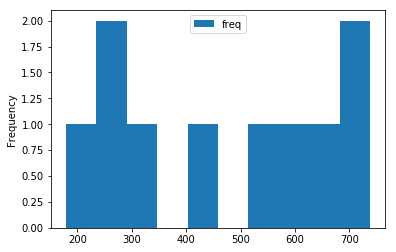

In [194]:
unique_brands[:10].plot(kind='hist')

In [195]:
unique_brands[:]

,freq
hyundai,738
chrysler,689
chevrolet,679
ford,587
mercedes,521
car,451
volkswagen,341
honda,244
acura,241
subaru,179


In [196]:
import numpy as np
from itertools import combinations, groupby
from collections import Counter

# Sample data
unique_brands_list = list(unique_brands.index.values)
def combination_of_2(set):
    return list(combinations(set,2))

posts['combinations_of_2']=posts['unique_brands'].map(combination_of_2)
set_of_1=posts['unique_brands'].sum()
set_of_2=posts['combinations_of_2'].sum()

from collections import Counter
count_1s=Counter(set_of_1)
count_2s=Counter(set_of_2)

In [197]:
unique_name=unique_brands.index.values
matrix = pd.DataFrame(index=unique_name, columns=unique_name)
for row in unique_name:
       for column in unique_name:
            if row==column:
                matrix.loc[row,column]=0
            else:
                matrix.loc[row,column]=((count_2s[(row, column)]+count_2s[(column, row)])*len(posts)*1.0)/(count_1s[row]*count_1s[column]*1.0)
matrix.iloc[:14,:14]

,hyundai,chrysler,chevrolet,ford,mercedes,car,volkswagen,honda,acura,subaru,buick,toyota,nissan,problem
hyundai,0,1.99671,0.328342,0.416857,0.125244,1.01278,0.590011,0.579424,5.21204,0.273402,1.64684,0.704883,0.250419,0.508559
chrysler,1.99671,0,2.43612,2.86754,0.122972,1.30435,1.62263,0.54902,0.0483351,0.227769,0.199693,0.970731,0.383183,1.00565
chevrolet,0.328342,2.43612,0,3.0608,0.249565,1.29735,0.953252,0.678215,0.269758,0.792424,3.47855,0.912062,0.544357,1.40313
ford,0.416857,2.86754,3.0608,0,0.223071,1.13688,0.741786,0.672438,0.226936,0.45831,0.273458,0.970608,0.719627,1.08203
mercedes,0.125244,0.122972,0.249565,0.223071,0,0.956407,0.496935,0.599784,0,0.129092,0.220071,0.998472,0.253372,1.16369
car,1.01278,1.30435,1.29735,1.13688,0.956407,0,1.93095,1.8963,0.775345,1.19303,1.06776,1.37315,1.40495,2.17649
volkswagen,0.590011,1.62263,0.953252,0.741786,0.496935,1.93095,0,0.627001,0.7813,5.06235,0.26899,1.45288,1.39362,1.35463
honda,0.579424,0.54902,0.678215,0.672438,0.599784,1.8963,0.627001,0,0.75068,1.9295,0.563888,2.23351,1.29843,1.30154
acura,5.21204,0.0483351,0.269758,0.226936,0,0.775345,0.7813,0.75068,0,0.0930249,0,0.205573,0.547745,0.479178
subaru,0.273402,0.227769,0.792424,0.45831,0.129092,1.19303,5.06235,1.9295,0.0930249,0,0.128109,2.491,1.47493,1.12901


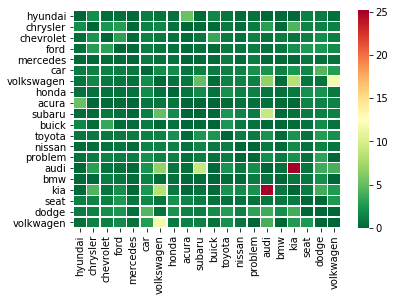

<Figure size 2160x1440 with 0 Axes>

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt
matrix_c = matrix.iloc[:20,:20].apply(pd.to_numeric, errors='coerce')
matrix_c
sns.heatmap(matrix_c, cmap='RdYlGn_r', linewidths=0.5)
plt.figure(figsize=(30,20))
plt.show()

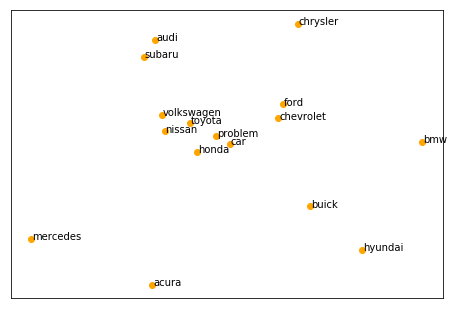

In [199]:
matrix_1=matrix.iloc[:16,:16]
matrix_1=matrix_1.replace(np.nan,0)

import numpy as np
from sklearn import manifold
from sklearn.manifold import MDS

mdsdf = 1/matrix_1

mdsdf=mdsdf.replace(np.nan,0)
mdsdf=mdsdf.replace(np.inf,0)

mdsmatrix=mdsdf.values

from matplotlib import pyplot as plt

mds=manifold.MDS(n_components=2, dissimilarity ='precomputed', random_state=10)

results=mds.fit(mdsmatrix)
coords=results.embedding_

x=coords[:,0]
y=coords[:,1]

ax=plt.axes([0.,0.,1.,1.])
plt.scatter(x,y,marker='o',color='orange')

n=list(mdsdf.index)

for i,n in enumerate(n):
    #print(x[i].item())
    #print(n)
    #print(type(y[i]))
    if n=='kia':
        ax.annotate(n,xy=((x[i]+.01),y[i]-.01))
    else:
        ax.annotate(n,xy=((x[i]+.01),y[i]-.02))

plt.xticks([])
plt.yticks([])

plt.show()

# Task B

The most interesting finding is the occurence of problem in the list. Brands Honda, Nissan , Toyota seems to be most problematic cars as per the audience popular view. Subaru being near to Audi is strange as it seems to be a competitor of Honda, Nissan, Toyota but interestingly it is very close to Audi. BMW and Mercedes being premier vehicle cars should have been very close but ironically they are most apart which wasn't expected at all. Audi, BMW and Mercedes presumably the most compared car combination are poles apart. Audi seems to be having stiff competition from Subaru which was again unexepected as Subaru targets middle ranged market whereas Audi targets Luxury driven market. The data tells Audi should shift their attention from BMW and Mercedes to Subaru or Volkswagen. Hyundai being clustered away from Ford, Honda, Chevrolet is ironic as they are the entry level market and should be preferrable be compared more with those brands.

In [200]:
unique_brands_superlist=posts['unique_brands'].sum()
top_5_brands=unique_brands[:5]
car_mapping1=car_mapping.merge(top_5_brands,left_on='brand',right_index=True,how='inner')
def mentioned_topbrands(list_1):
    list_i=pd.DataFrame(list_1)
    mask=car_mapping1['model'].isin(pd.Series(list_1))
    joiner=car_mapping1[mask]
    joined=joiner.merge(list_i, left_on='model', right_on=0)
    out=set(list(joined['brand']))
    return list(out)

posts['unique_topbrands']=posts['unique_words_list'].map(mentioned_topbrands)

In [201]:
# replacing models and brands with empty string"

def joining(s):
    s1=" ".join(s)
    return s1
posts['words combined']=posts['unique_words_list1']=posts['unique_words_list'].map(joining)
a=posts['words combined'].str.cat(sep = ' ')
brand=list(car_mapping['brand'])
brand1=[]
for i in brand:
    j=str(i).replace(' ','')
    brand1.append(j)
for p in brand1:
    a1=str(a).replace(p,"")

for p in list(car_mapping['model']):
    a2=str(a1).replace(p,"")

In [202]:
a2

'24 entrylevel true is local i strange terms 2015 for better at exl in this a same every less rear acura that deal four an seat seems than used accord 50k c2000 159k like but significantly owned can tlx of another dealer with the good accords having way roomy miles luxury httpswwwacuraatoxmoorcomusedacura2015acuratlxfcaa14f30a0e0a6b0a96f79e5affff39htm httpswwwlouisvillehondaworldcomusedjeffersoncounty2015hondaaccordexl1hgcr2f83fa029458 about little say otherwise almost least hyundai i tech have combo dont base mine nice at a really color without 2018 rdx acura more package on but like awd stuff tlx sport them 2018s the and 2013 elantra wifes lot these ive acurawatch sound is expensive blind i tech have combo acuralink base few 4wheel carplayandroidauto for nice at well price navi does some wipers builtin a c3700 alert spot leather later monitors plus that package cross it any system used seats id transmission milano imho engine rainsensing even not but els times stuff smell 159k still 

In [146]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [203]:
import enchant
from pandas import Series, DataFrame

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wordsList = a2.split()
diction = dict()
englishDictionary = enchant.Dict("en_US")

for words in wordsList:
    if(words not in stopwords.words('english')):
        if(englishDictionary.check(words)):
            if words not in diction:
                diction[words]=1
            else:
                diction[words]+=1
        
print(type(diction))
sorted_List = sorted(diction.items(), key=lambda x: x[1], reverse=True)


<class 'dict'>


In [204]:
sorted_List

[('said', 1676),
 ('2015', 1408),
 ('one', 1065),
 ('like', 1026),
 ('2018', 1012),
 ('car', 983),
 ('would', 954),
 ('2014', 935),
 ('get', 880),
 ('2017', 795),
 ('new', 679),
 ('good', 664),
 ('time', 657),
 ('think', 644),
 ('back', 585),
 ('need', 572),
 ('know', 555),
 ('show', 551),
 ('much', 517),
 ('go', 504),
 ('previous', 502),
 ('really', 494),
 ('got', 493),
 ('2013', 492),
 ('quotes', 477),
 ('years', 475),
 ('could', 472),
 ('2016', 463),
 ('well', 458),
 ('see', 457),
 ('sport', 454),
 ('cars', 451),
 ('vehicle', 442),
 ('even', 439),
 ('2008', 437),
 ('still', 417),
 ('people', 415),
 ('wifes', 413),
 ('mine', 400),
 ('name', 399),
 ('going', 398),
 ('way', 395),
 ('mustang', 392),
 ('year', 383),
 ('2009', 372),
 ('long', 367),
 ('first', 365),
 ('take', 364),
 ('lot', 363),
 ('last', 362),
 ('make', 362),
 ('never', 360),
 ('share', 355),
 ('right', 348),
 ('gt', 347),
 ('reviews', 342),
 ('2011', 339),
 ('thats', 327),
 ('better', 325),
 ('sure', 324),
 ('moderator'

In [169]:
df = pd.DataFrame(sorted_List, columns = ("words","count"))
wordCount_File = r'/Users/jitu/Documents/Fall/UGC/wordCountFile.csv'
df.to_csv(wordCount_File)

In [220]:
attrbute_mapping=pd.read_csv("/Users/jitu/Documents/Fall/UGC/wordCountFile.csv")
attrbute_mapping.head(5)

,words,count,classification
0,2015,1408,NaN
1,one,1065,NaN
2,like,1026,emotions
3,2018,1012,NaN
4,car,983,NaN


In [221]:
attrbute_mapping=attrbute_mapping.dropna(how='any')
attrbute_mapping.head(5)

,words,count,classification
2,like,1026,emotions
9,new,679,durability
10,good,664,performance
11,time,657,durability
14,need,572,emotions


In [222]:
top5_brands=unique_brands[:5]
top5_brands

,freq
hyundai,738
chrysler,689
chevrolet,679
ford,587
mercedes,521


In [223]:
from pandas import Series, DataFrame
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
s = re.findall('\w+', a2)
s = [w for w in s if not w in stop_words]
lemmatizer = WordNetLemmatizer()
s = Series(s).map(lemmatizer.lemmatize)
attribute_freq=DataFrame(s.value_counts())

In [224]:
posts

,Unnamed: 0,Date,User,Text,unique_words_list,unique_brands,combinations_of_2,unique_topbrands,words combined,unique_words_list1,unique_attributes,brand_attr,combinations_of_2_1,combinations_of_brandattr
0,0,September 28,benjaminhf,This seems like a good deal in terms of used e...,"[24, entrylevel, true, is, local, i, strange, ...",[honda],[],[],24 entrylevel true is local i strange terms 20...,24 entrylevel true is local i strange terms 20...,"[features, emotions, Performance, performance]","[features, emotions, Performance, performance]","[(emotions, performance), (features, Performan...","[(features, emotions), (features, Performance)..."
1,1,September 28,stickguy,nice color combo on the TLX. But I really don'...,"[least, hyundai, i, tech, have, combo, dont, b...","[hyundai, acura]","[(hyundai, acura)]",[hyundai],least hyundai i tech have combo dont base mine...,least hyundai i tech have combo dont base mine...,"[emotions, performance]","[hyundai, emotions, performance]","[(hyundai, performance), (hyundai, emotions), ...","[(hyundai, emotions), (hyundai, performance), ..."
2,2,September 28,benjaminhf,"Yeah, the Tech package for the TLX is expensiv...","[ive, acurawatch, sound, is, expensive, blind,...","[hyundai, seat]","[(hyundai, seat)]",[hyundai],ive acurawatch sound is expensive blind i tech...,ive acurawatch sound is expensive blind i tech...,"[performance, features, durability, profitabil...","[hyundai, performance, features, durability, p...","[(features, profitability), (hyundai, performa...","[(hyundai, performance), (hyundai, features), ..."
3,3,October 3,benjaminhf,Thinking about the idea @stickguy had of keepi...,"[ive, is, i, half, have, year, keeping, though...","[honda, acura]","[(honda, acura)]",[],ive is i half have year keeping though 25 for ...,ive is i half have year keeping though 25 for ...,"[emotions, durability, performance]","[emotions, durability, performance]","[(emotions, performance), (durability, perform...","[(emotions, durability), (emotions, performanc..."
4,4,October 3,benjaminhf,Entry level luxury sedan sales for last month....,"[is, 11, es, mkz, 467, 244, sedan, for, well, ...","[volvo, lincoln, infiniti, acura, audi]","[(volvo, lincoln), (volvo, infiniti), (volvo, ...",[],is 11 es mkz 467 244 sedan for well g70 month ...,is 11 es mkz 467 244 sedan for well g70 month ...,[profitability],[profitability],[],[]
5,5,October 3,stickguy,"Ouch 2018 Hyundai Elantra Sport (mine), and 20...","[hyundai, 2018, rdx, awd, and, mine, ouch, 201...","[hyundai, acura]","[(hyundai, acura)]",[hyundai],hyundai 2018 rdx awd and mine ouch 2013 acura ...,hyundai 2018 rdx awd and mine ouch 2013 acura ...,"[emotions, performance]","[hyundai, emotions, performance]","[(hyundai, performance), (hyundai, emotions), ...","[(hyundai, emotions), (hyundai, performance), ..."
6,6,October 4,benjaminhf,But falling sales for ELL cars probably helps ...,"[least, manual, 2016, keep, bmw, i, falling, o...","[honda, car]","[(honda, car)]",[],least manual 2016 keep bmw i falling out thats...,least manual 2016 keep bmw i falling out thats...,"[performance, features, Performance, durabilit...","[performance, features, Performance, durabilit...","[(features, Performance), (features, profitabi...","[(performance, features), (performance, Perfor..."
7,7,October 4,stickguy,"But, will be nice if they keep the pricing lik...","[they, keep, is, i, will, hyundai, mine, prici...","[hyundai, acura]","[(hyundai, acura)]",[hyundai],they keep is i will hyundai mine pricing nice ...,they keep is i will hyundai mine pricing nice ...,"[emotions, performance]","[hyundai, emotions, performance]","[(hyundai, performance), (hyundai, emotions), ...","[(hyundai, emotions), (hyundai, performance), ..."
8,8,October 4,benjaminhf,"stickguy said: But, will be nice if they keep ...","[keep, i, raise, bmw, falling, base, pricing, ...","[honda, car]","[(honda, car)]",[],keep i raise bmw falling base pricing acura ce...,keep i raise bmw falling base pricing acura 

In [225]:
def mentioned_attributes(list_1):
    list_i=pd.DataFrame(list_1)
    mask=attrbute_mapping['words'].isin(pd.Series(list_1))
    joiner=attrbute_mapping[mask]
    joined=joiner.merge(list_i, left_on='words', right_on=0)
    out=set(list(joined['classification'].dropna()))
    return list(out)

posts['unique_attributes']=posts['unique_words_list'].map(mentioned_attributes)

In [226]:
posts['unique_attributes']

0                       [features, emotions, performance]
1                                 [emotions, performance]
2       [performance, features, durability, profitabil...
3                     [emotions, durability, performance]
4                                         [profitability]
5                                 [emotions, performance]
6       [performance, features, durability, profitabil...
7                                 [emotions, performance]
8       [emotions, durability, profitability, performa...
9                     [emotions, durability, performance]
10       [features, emotions, profitability, performance]
11                                 [emotions, durability]
12                 [features, profitability, performance]
13                 [emotions, profitability, performance]
14                 [features, profitability, performance]
15                                [emotions, performance]
16               [durability, profitability, performance]
17            

In [227]:
posts['brand_attr']=posts['unique_topbrands']+posts['unique_attributes']

In [228]:
##If you want distinct count of frequencies of attributes
unique_attributes=nltk.FreqDist(posts['unique_attributes'].sum())
unique_attributes=pd.DataFrame.from_dict(unique_attributes, orient='index', columns=['freq']).sort_values(by='freq', ascending=False)
unique_attributes[:5]

,freq
performance,2442
emotions,2330
features,1868
durability,1511
profitability,1130


Top Feature is Emotions (ex. happy, sad, angry, love, like)

In [229]:
# Sample data
unique_attributes_list = list(unique_attributes.index.values)

In [230]:
#Brand_associations

from itertools import combinations
def combination_of_2(set):
    return list(combinations(set,2))

posts['combinations_of_2_1']=posts['brand_attr'].map(combination_of_2)

In [243]:
posts['combinations_of_2_1']


0       [(emotions, performance), (features, emotions)...
1       [(hyundai, performance), (hyundai, emotions), ...
2       [(features, profitability), (hyundai, performa...
3       [(emotions, performance), (durability, perform...
4                                                      []
5       [(hyundai, performance), (hyundai, emotions), ...
6       [(features, profitability), (durability, emoti...
7       [(hyundai, performance), (hyundai, emotions), ...
8       [(emotions, profitability), (emotions, perform...
9       [(emotions, performance), (emotions, durabilit...
10      [(emotions, profitability), (emotions, perform...
11                               [(emotions, durability)]
12      [(features, profitability), (profitability, pe...
13      [(emotions, performance), (emotions, profitabi...
14      [(features, profitability), (features, perform...
15      [(hyundai, performance), (hyundai, emotions), ...
16      [(hyundai, profitability), (hyundai, performan...
17      [(emot

In [231]:
#Time taking chunk of code
for i in range(len(posts)):
    posts['combinations_of_2_1'][i]=list(set(posts['combinations_of_2_1'][i])-set(posts['combinations_of_2'][i]))

In [233]:
posts['combinations_of_brandattr']=posts['brand_attr'].map(combination_of_2)
posts['combinations_of_brandattr']

0       [(features, emotions), (features, performance)...
1       [(hyundai, emotions), (hyundai, performance), ...
2       [(hyundai, performance), (hyundai, features), ...
3       [(emotions, durability), (emotions, performanc...
4                                                      []
5       [(hyundai, emotions), (hyundai, performance), ...
6       [(performance, features), (performance, durabi...
7       [(hyundai, emotions), (hyundai, performance), ...
8       [(emotions, durability), (emotions, profitabil...
9       [(hyundai, emotions), (hyundai, durability), (...
10      [(hyundai, features), (hyundai, emotions), (hy...
11                               [(emotions, durability)]
12      [(features, profitability), (features, perform...
13      [(hyundai, emotions), (hyundai, profitability)...
14      [(chrysler, features), (chrysler, profitabilit...
15      [(hyundai, emotions), (hyundai, performance), ...
16      [(hyundai, durability), (hyundai, profitabilit...
17      [(hyun

In [244]:
set_of_1_comb=posts['combinations_of_2_1'].sum()

In [245]:
set_of_2_attr=posts['unique_attributes'].sum()
set_of_2_attr[:3]

['features', 'emotions', 'performance']

In [246]:
from collections import Counter
count_2s_comb=Counter(set_of_1_comb)
# count_2s_comb is a dictionary with count of occurences of pairs

In [248]:
count_1_attr=Counter(posts['brand_attr'].sum())
# count_1_attr is a dictionary with count of occurences of pairs

In [249]:
unique_row_name=top5_brands.index.values
unique_column_name=unique_attributes.index.values
matrix_ba = pd.DataFrame(index=unique_row_name, columns=unique_column_name)

In [250]:
for row in unique_row_name:
       for column in unique_column_name:
            if count_1_attr[row]*count_1_attr[column]==0:
                matrix_ba.loc[row,column]=0
            else:
                matrix_ba.loc[row,column]=((count_2s_comb[(row, column)]+count_2s_comb[(column, row)])*1.0)*len(posts)/(count_1_attr[row]*count_1_attr[column])*1.0

In [251]:
matrix_ba = matrix_ba.apply(pd.to_numeric, errors='coerce')
matrix_ba

,performance,emotions,features,durability,profitability
hyundai,1.282595,1.295239,0.695719,0.834904,0.842117
chrysler,0.896793,0.917403,1.334495,1.110141,1.139105
chevrolet,0.960825,1.072961,1.673702,1.063907,1.040816
ford,1.010631,0.962385,1.570043,1.253275,1.119243
mercedes,0.798006,0.816531,0.758704,1.090889,0.933842


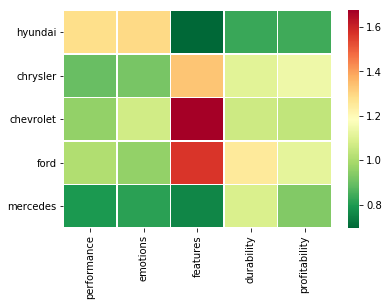

In [252]:
sns.heatmap(matrix_ba, cmap='RdYlGn_r', linewidths=0.5)

# Task D 

# What advice will you give to a (i) product manager, and (ii) marketing/advertising manager of these brands based on your analysis in Task C? For this assignment, you can assume the sentiment (e.g., that it is positive).

The most interesting outcome has been the position of Mercedes in our matrix. Mercedes  which is widely renowned for quality and durability; nonethless the same is not refelcted through the public perception atleast in the eyes of user data extracted through our forum.In fact except for durability it is lowest in terms of performance, features and emotions captured in our dataset. The biggest insight for product Manager of Mercedes would be to focus on performance and features provided. Mercedes is losing one of its greatest charm that is features. From the matrix it is clear that the people are more driven towards other brands with respect to these attributes. 
Chevrolet on the other hand has also surprised us with its outcome.The product manager of Chevrolet needs to concentrate more on performance and also collectively a little more effort is required for other features as well.The product manager of Hyundai should make sure that the features such as looks, sound output, tyres, headlights etc. are also given equal importance.

The Marketing manager of mercedes should focus more on advertising for it as it is losing its greatness which it once had.Hyundai claims for its mordernness but the same is not reflected according to the public perceptions.The marketing manager of hyundai should project the image of hyundai in such a way so that it aligns with the matrix above. He/She should focus on how to highlight some of the key features and make them popular again. The marketing managers of Ford and Chevrolet should brig to light features(looks, sound output etc) as the peopleare impacted the greatest by features of Chevrolet.It can become the stepping stone for sales. Sales can increase manifold if the strongest points are projected in a way such that it affects a greater mass.

# Task E

Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?

Surprisingly our analysis revealed that different cars are famous among audience for different reasons. There was no single drift towards one particular car. Still, if we analyze the data closely then we can infer that there is a tough competition between Ford and Chevrolet. In the opinion of the audience, these two cars are strong competitors in terms of ‘Features’. The common features that people talk about are- convertible, looks, tires, sounds etc. The strong association of features with these two brands shows that the audience is more inclined towards these two brands as compared to others. But, features can’t be the only judging parameter. One other important parameter to gauge the interest of audience is ‘Performance’. As we can see from the heat map that Ford beats Chevrolet in terms of performance but lags behind in terms of Features. As these two are equally important aspects that people consider when buying a car, there has to be some other deciding factor or trade-off between these two. In terms of both Durability and Profitability Ford beats Chevrolet significantly if not entirely. 

So from the above discussion it will be fair to conclude that Ford is high in audience’s opinion in terms of Durability, Profitability and Performance whereas Chevrolet is marginally high in terms of Features and Emotions. Since Emotions is a slightly vague and abstract term when it comes to deciding which car to buy (hence we evaluate both cars equally here), we can say that the Ford turns out to be game winner with a score of (3.5/5.0)!

Business Implications for this brand:

Although Ford comes out to be the most aspirational brand, there are few key insights which are important to be considered:
•	People have significant high emotions and performance for Hyundai. This can turn out to be problematic for Ford in long run (if at all Hyundai regains people confidence in terms of other attributes).
•	Also, we can say that Ford has performed well only in terms of features, whereas all other Lift values are not that strong. This shows that people are valuing Ford because it is serving as Jack of All [But Master of None] (Except features). This can cause problems in terms of future market prospects.